# Cleaning the datasets

### Importing libraries

In [2]:
# Numpy
import numpy as np
from numpy import concatenate, array
from numpy.random import randn
# Decimal precision value to display in the matrix
np.set_printoptions(precision=5, suppress=True)

# Scipy
import scipy
import scipy.stats as stats

# Matplotlib
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
#mpl.rc('figure', figsize=(10, 8))

# Pandas experiments
import pandas as pd
from pandas import Series, DataFrame, Panel

# Misc
import time
import datetime as dt
import math
import random
# import seaborn as sns
print 'All libraries loaded.'

All libraries loaded.


# Make dataframes from data

In [199]:
# Make dataframes from data

# eGFR data
egfr_df = pd.read_csv('~/code/independent/datasets/cdr_gfr_derived.csv', parse_dates=['resultdata'])
egfr_df.drop('gfr', axis=1, inplace=True)
egfr_df.columns = ['pid', 'timestamp', 'gender', 'birthyear', 'age', 'gfr']

# Findings data
findings_df = pd.read_csv('~/code/independent/datasets/cdr_finding.csv', parse_dates=['finddate'], usecols=['idperson', 'finddate', 'valuename', 'findvalnum'])
findings_df = findings_df[['idperson', 'finddate', 'valuename', 'findvalnum']]
findings_df.columns = ['pid', 'timestamp', 'testname', 'testval']

# Lab reports data
lab_df = pd.read_csv('~/code/independent/datasets/cdr_lab_result.csv', parse_dates=['resultdate'], usecols=['idperson', 'resultdate', 'valuename', 'resultvaluenum'])
lab_df = lab_df[['idperson', 'resultdate', 'valuename', 'resultvaluenum']]
lab_df.columns = ['pid', 'timestamp', 'testname', 'testval']
# Make all lab tests values uppercase
lab_df.testname = map(lambda x: x.upper(), lab_df.testname)

In [200]:
# Normalize dates (to remove the time part of it)
egfr_df.timestamp = egfr_df.timestamp.map(pd.datetools.normalize_date)
findings_df.timestamp = findings_df.timestamp.map(pd.datetools.normalize_date)
lab_df.timestamp = lab_df.timestamp.map(pd.datetools.normalize_date)

In [201]:
# NaN values
total_rowcount = len(lab_df.testval.values)
nan_rowcount = len([x for x in lab_df.testval.values if math.isnan(x)])
print '\n',(str(nan_rowcount*100/total_rowcount)+ "% of the values are NaN")

# Drop NaN rows
# lab_df.dropna(inplace=True)


1% of the values are NaN


## Make a multi-index/hierarchical index 
#### The index will be a combination of the PID (person ID) and timestamp

In [6]:
# Set the index as a combination of the person ID and timestamp
egfr_df.set_index(['pid', 'timestamp'], inplace=True)
findings_df.set_index(['pid', 'timestamp'], inplace=True)
lab_df.set_index(['pid', 'timestamp'], inplace=True)

## Get list of all patients for whom we have eGFR data

In [7]:
list_of_patients = list(set(egfr_df.index.get_level_values('pid').values))
print '\nFound', len(list_of_patients), 'unique patients'


Found 63215 unique patients


## Make the new dataframe (empty)

In [202]:
# Column names will be a combination of all the lab test names and finding names
unique_findings = set(findings_df.testname.values)
unique_labtests = set(lab_df.testname.values)
print '\nFindings:', list(unique_findings)
print 'Lab tests:', list(unique_labtests)
final_col_names = np.append(list(unique_findings), list(unique_labtests))


Findings: ['FND_WTLB', 'FND_BPS', 'FND_BPD', 'FND_HTIN']
Lab tests: ['LR_AST', 'LR_MICROCR', 'LR_HDL', 'LR_TRIG', 'LR_A1C', 'LR_CR', 'LR_PTH', 'LR_GLUCNONFAST', 'LR_GLUCFAST', 'LR_LDL', 'LR_GFR', 'LR_VITD 25', 'LR_ALT', 'LR_VITD 1_25', 'LR_PHOS', 'LR_GFR_AFRAMER']


In [10]:
# Row locations in the eGFR dataframe of patients
# locations_of_patients = []
# for patient in list_of_patients:
#     get_loc_result = egfr_df.index.get_loc(patient)
#     locations_of_patients += [i for i,v in enumerate(get_loc_result) if v == True]

# combined_df = DataFrame(egfr_df.iloc[locations_of_patients])
combined_df = pd.DataFrame(egfr_df)

# Add the new columns
for newcol in final_col_names:
    combined_df[newcol] = np.nan

## Fill values into the new dataframe<br>based on joins on the other dataframes

In [13]:
def fill_data(source_df, patient_id):
    
    ############### Could optimize
    locations_of_patients = []
    if str(patient_id) in source_df.index:
        
#         get_loc_result = source_df.index.get_loc(str(patient_id))
#         locations_of_patients += [i for i,v in enumerate(get_loc_result) if v == True]
#         this_patients_data = source_df.iloc[locations_of_patients]
        this_patients_data = source_df.loc[str(patient_id)]

        # We only need data for the dates that exist in the combined DF already 
        # (the ones that have eGFR readings)
        for timestamp in combined_df.loc[patient_id].index:
            if timestamp in this_patients_data.index.get_level_values('timestamp'):
                this_patient = this_patients_data.loc[timestamp]

                # Set the value in the DF for this test
                # Check if there's multiple values for the same timestamp
                if type(this_patient) == pd.core.frame.DataFrame:
                    for i in range(this_patient.testname.size):
                        
                        try:
                            combined_df.loc[(patient_id, timestamp), this_patient.testname[i]] = this_patient.testval[i]
                        except:
                            print 'multivalues for', patient_id
                else:
                    combined_df.loc[(patient_id, timestamp), this_patient.testname] = this_patient.testval

                    
fill_count = 0
start_time = time.time()
lastseen_time = time.time()

for patient_id in list_of_patients:
    
    if fill_count % 500 == 0:
        elapsed_time = time.time() - lastseen_time
        lastseen_time = time.time()
        print 'Data fill for', fill_count, 'patients completed in', '{:.3f}'.format(elapsed_time), 'seconds'
    fill_count += 1
    
#     ########################################## REMOVE
#     if fill_count < 14001:
#         continue
    
    # Check if the findings df has data about this patient
    fill_data(findings_df, patient_id)

    # Check if the lab-tests df has data about this patient
    fill_data(lab_df, patient_id)
    
    
elapsed_time = time.time() - start_time
print 'Task completed in', '{:.3f}'.format(elapsed_time), 'seconds'

Data fill for 0 patients completed in 0.000 seconds
Data fill for 500 patients completed in 157.239 seconds
Data fill for 1000 patients completed in 213.652 seconds
Data fill for 1500 patients completed in 222.478 seconds
Data fill for 2000 patients completed in 185.968 seconds
Data fill for 2500 patients completed in 193.586 seconds
Data fill for 3000 patients completed in 312.431 seconds
Data fill for 3500 patients completed in 286.072 seconds
Data fill for 4000 patients completed in 108.058 seconds
Data fill for 4500 patients completed in 216.104 seconds
Data fill for 5000 patients completed in 200.301 seconds
Data fill for 5500 patients completed in 167.326 seconds
Data fill for 6000 patients completed in 189.163 seconds
Data fill for 6500 patients completed in 159.524 seconds
Data fill for 7000 patients completed in 173.184 seconds
Data fill for 7500 patients completed in 202.893 seconds
Data fill for 8000 patients completed in 201.204 seconds
Data fill for 8500 patients completed

## Fill in smoking status values into the dataframe

In [118]:
# Smoking data
smoke_df = pd.read_csv('~/code/independent/datasets/cdr_history_social.csv', usecols=['idperson', 'valuename'])
smoke_df.columns = ['pid', 'smoker_status']
# Make all lab tests values uppercase
# lab_df.testname = map(lambda x: x.upper(), lab_df.testname)

before_dropping = smoke_df.shape[0]
# Drop duplicate rows 
smoke_df.drop_duplicates(subset='pid', keep='first', inplace=True)
after_dropping = smoke_df.shape[0]
print '\n# of records before dropping duplicates:', before_dropping
print '# of records after dropping duplicates:', after_dropping

# Set the patient ID as the index
smoke_df.set_index('pid', inplace=True)


# of records before dropping duplicates: 1059065
# of records after dropping duplicates: 63314


In [194]:
patients_with_smokedata = [x for x in list_of_patients if x in smoke_df.index]
print "\n{:.2f}%".format(len(patients_with_smokedata)*100.0/len(list_of_patients)), 'of the patients have smoking data.'
print 'We will need to impute the missing data for the remaining', "{:.2f}%".format((len(list_of_patients)-len(patients_with_smokedata))*100.0/len(list_of_patients)), 'of the patients.'


90.99% of the patients have smoking data.
We will need to impute the missing data for the remaining 9.01% of the patients.


In [180]:
# Make an empty column for smoker status in the DF
combined_df['smoker_status'] = np.nan

# Fill in smoking status values for all the patients
def set_smoker_status(pid):
    combined_df.loc[(pid), 'smoker_status'] = smoke_df.loc[pid].smoker_status
map(set_smoker_status, patients_with_smokedata)

In [202]:
# Put the eGFR column last, and bring the smoker_status column in into it's place
col_list = combined_df.columns.tolist()
col_list[3] = 'smoker_status'
col_list[-1] = 'gfr'
combined_df = combined_df[col_list]

In [203]:
combined_df

gender  birthyear  age   smoker_status   FND_WTLB  FND_BPS  \
pid     timestamp                                                               
8545332 2006-08-11      F       1924   90  SOC_PastSmoker  152.50000      120   
        2006-11-02      F       1924   90  SOC_PastSmoker  156.00000      118   
        2007-06-05      F       1924   90  SOC_PastSmoker  157.00000      150   
        2010-02-09      F       1924   90  SOC_PastSmoker  163.00000      164   
        2010-08-17      F       1924   90  SOC_PastSmoker  162.00000      135   
        2011-04-13      F       1924   90  SOC_PastSmoker  163.00000      146   
8545333 2007-05-31      F       1941   73   SOC_NonSmoker  147.00000      130   
        2010-06-10      F       1941   73   SOC_NonSmoker        NaN      NaN   
        2010-06-10      F       1941   73   SOC_NonSmoker        NaN      NaN   
8545336 2010-11-18      F       1928   86   SOC_NonSmoker  121.00000      147   
        2011-09-01      F       1928   86   SOC_NonSmoker  113.00000      115   
8545337 2010-10-29      F       1924   90  SOC_PastSmoker        NaN      120   
8545338 2007-10-11      F       1948   66   SOC_NonSmoker  141.00000      140   
8545339 2010-05-24      F       1946   68   SOC_NonSmoker  270.00000      155   
        2010-05-24      F       1946   68   SOC_NonSmoker  270.00000      155   
8545340 2007-04-19      F       1926   88   SOC_NonSmoker  141.00000      140   
        2007-10-01      F       1926   88   SOC_NonSmoker  248.00000      140   
        2007-10-09      F       1926   88   SOC_NonSmoker        NaN      NaN   
        2008-12-18      F       1926   88   SOC_NonSmoker  150.00000      NaN   
8545341 2006-12-06      F       1943   71             NaN  183.00000      132   
        2007-03-26      F       1943   71             NaN  189.00000      118   
8545342 2007-02-20      F       1931   83  SOC_PastSmoker  128.00000      106   
        2007-07-19      F       1931   83  SOC_PastSmoker  128.00000      112   
8545344 2007-11-26      F       1954   60      SOC_Smoker  194.00000      128   
8545345 2009-06-25      F       1950   64  SOC_PastSmoker  295.00000      106   
8545346 2009-01-15      F       1950   64   SOC_NonSmoker  128.00000      139   
8545347 2010-10-29      F       1955   59   SOC_NonSmoker  176.00000      123   
        2010-10-29      F       1955   59   SOC_NonSmoker  176.00000      123   
8545348 2006-08-10      F       1941   73   SOC_NonSmoker  197.00000      180   
        2009-05-04      F       1941   73   SOC_NonSmoker  182.00000      137   
...                   ...        ...  ...             ...        ...      ...   
9581790 2011-05-06      M       1925   89             NaN  107.00136      120   
9581791 2011-08-29      M       1928   86             NaN        NaN      NaN   
9581793 2011-09-02      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2011-09-02      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2011-11-08      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2012-02-15      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2012-03-01      M       1935   79  SOC_PastSmoker        NaN      NaN   
9581799 2011-06-24      M       1926   88             NaN        NaN      NaN   
9581800 2011-01-06      M       1936   78             NaN        NaN      NaN   
        2011-03-08      M       1936   78             NaN        NaN      NaN   
        2011-08-08      M       1936   78             NaN        NaN      NaN   
        2011-10-18      M       1936   78             NaN        NaN      NaN   
        2012-01-24      M       1936   78             NaN        NaN      NaN   
9581801 2011-03-30      M       1942   72             NaN        NaN      NaN   
        2011-07-20      M       1942   72             NaN        NaN      NaN   
        2011-08-16      M       1942   72             NaN        NaN      NaN   
        2011-11-19      M       1942   72         

## Visualize how much lab-test/findings data <br>we really have corresponding to eGFR data

In [203]:
# How many values are NaNs
how_much_data_missing = []
for col_name in final_col_names:
    total_rowcount = len(combined_df[col_name].values)
    nan_rowcount = len([x for x in combined_df[col_name].values if math.isnan(x)])
    print (str(nan_rowcount*100/total_rowcount)+ "% of the values in " + col_name + ' are NaN')
    how_much_data_missing.append(nan_rowcount*100/total_rowcount)

55% of the values in FND_WTLB are NaN
52% of the values in FND_BPS are NaN
52% of the values in FND_BPD are NaN
71% of the values in FND_HTIN are NaN
31% of the values in LR_AST are NaN
91% of the values in LR_MICROCR are NaN
42% of the values in LR_HDL are NaN
42% of the values in LR_TRIG are NaN
67% of the values in LR_A1C are NaN
0% of the values in LR_CR are NaN
99% of the values in LR_PTH are NaN
15% of the values in LR_GLUCNONFAST are NaN
88% of the values in LR_GLUCFAST are NaN
43% of the values in LR_LDL are NaN
51% of the values in LR_GFR are NaN
95% of the values in LR_VITD 25 are NaN
34% of the values in LR_ALT are NaN
99% of the values in LR_VITD 1_25 are NaN
98% of the values in LR_PHOS are NaN
81% of the values in LR_GFR_AFRAMER are NaN


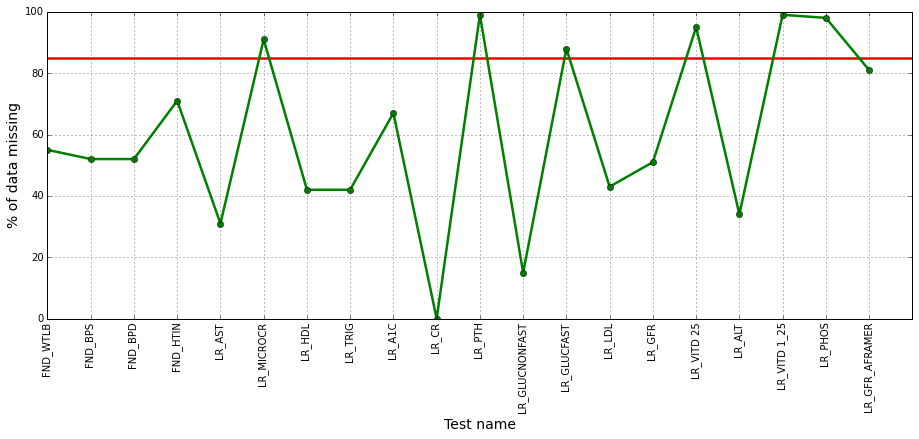

In [204]:
threshold = 85

figure = plt.figure()
figure.set_size_inches(15.5, 5.5)
xaxisvals = [i for i,val in enumerate(final_col_names)]
plt.plot(xaxisvals, how_much_data_missing, linewidth=2.5, c='g', marker='o')
plt.xticks(xaxisvals, final_col_names, rotation=90)
plt.xlabel("Test name", fontsize=14)
plt.ylabel("% of data missing", fontsize=14)
plt.axhline(y=threshold, c="red",linewidth=2.5,zorder=0)
plt.grid()
plt.show()

## Write the resultant DF to a CSV file

In [ ]:
output_file_path = 'combined_df.csv'
combined_df.to_csv(output_file_path, sep='\t')

In [195]:
# Read intermediate temporary file
combined_df = pd.read_csv('~/code/independent/datasets/combined_df.csv', delimiter='\t', index_col=('pid','timestamp'))

## Remove columns from the DF for which too much data is missing

#### We don't want to use columns for which too much data is missing. Columns for <br>which the missing data crosses a configured threshold (80% as a heuristic) will be dropped

In [205]:
cols_to_drop = [i for i, val in enumerate(how_much_data_missing) if val > threshold]
# Add offset
cols_to_drop = np.add(cols_to_drop, 4)
print 'Dropping these columns from the DF:\n', combined_df.columns[cols_to_drop].tolist()
combined_df.drop(combined_df.columns[cols_to_drop], axis=1, inplace=True)
print '\nColumns dropped. There are now', combined_df.shape[1], 'columns in the DF'

Dropping these columns from the DF:
['LR_MICROCR', 'LR_PTH', 'LR_GLUCFAST', 'LR_VITD 25', 'LR_VITD 1_25', 'LR_PHOS']

Columns dropped. There are now 19 columns in the DF


In [207]:
# After dropping columns with high amounts of missing data
combined_df

gender  birthyear  age   smoker_status   FND_WTLB  FND_BPS  \
pid     timestamp                                                               
8545332 2006-08-11      F       1924   90  SOC_PastSmoker  152.50000      120   
        2006-11-02      F       1924   90  SOC_PastSmoker  156.00000      118   
        2007-06-05      F       1924   90  SOC_PastSmoker  157.00000      150   
        2010-02-09      F       1924   90  SOC_PastSmoker  163.00000      164   
        2010-08-17      F       1924   90  SOC_PastSmoker  162.00000      135   
        2011-04-13      F       1924   90  SOC_PastSmoker  163.00000      146   
8545333 2007-05-31      F       1941   73   SOC_NonSmoker  147.00000      130   
        2010-06-10      F       1941   73   SOC_NonSmoker        NaN      NaN   
        2010-06-10      F       1941   73   SOC_NonSmoker        NaN      NaN   
8545336 2010-11-18      F       1928   86   SOC_NonSmoker  121.00000      147   
        2011-09-01      F       1928   86   SOC_NonSmoker  113.00000      115   
8545337 2010-10-29      F       1924   90  SOC_PastSmoker        NaN      120   
8545338 2007-10-11      F       1948   66   SOC_NonSmoker  141.00000      140   
8545339 2010-05-24      F       1946   68   SOC_NonSmoker  270.00000      155   
        2010-05-24      F       1946   68   SOC_NonSmoker  270.00000      155   
8545340 2007-04-19      F       1926   88   SOC_NonSmoker  141.00000      140   
        2007-10-01      F       1926   88   SOC_NonSmoker  248.00000      140   
        2007-10-09      F       1926   88   SOC_NonSmoker        NaN      NaN   
        2008-12-18      F       1926   88   SOC_NonSmoker  150.00000      NaN   
8545341 2006-12-06      F       1943   71             NaN  183.00000      132   
        2007-03-26      F       1943   71             NaN  189.00000      118   
8545342 2007-02-20      F       1931   83  SOC_PastSmoker  128.00000      106   
        2007-07-19      F       1931   83  SOC_PastSmoker  128.00000      112   
8545344 2007-11-26      F       1954   60      SOC_Smoker  194.00000      128   
8545345 2009-06-25      F       1950   64  SOC_PastSmoker  295.00000      106   
8545346 2009-01-15      F       1950   64   SOC_NonSmoker  128.00000      139   
8545347 2010-10-29      F       1955   59   SOC_NonSmoker  176.00000      123   
        2010-10-29      F       1955   59   SOC_NonSmoker  176.00000      123   
8545348 2006-08-10      F       1941   73   SOC_NonSmoker  197.00000      180   
        2009-05-04      F       1941   73   SOC_NonSmoker  182.00000      137   
...                   ...        ...  ...             ...        ...      ...   
9581790 2011-05-06      M       1925   89             NaN  107.00136      120   
9581791 2011-08-29      M       1928   86             NaN        NaN      NaN   
9581793 2011-09-02      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2011-09-02      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2011-11-08      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2012-02-15      M       1935   79  SOC_PastSmoker        NaN      NaN   
        2012-03-01      M       1935   79  SOC_PastSmoker        NaN      NaN   
9581799 2011-06-24      M       1926   88             NaN        NaN      NaN   
9581800 2011-01-06      M       1936   78             NaN        NaN      NaN   
        2011-03-08      M       1936   78             NaN        NaN      NaN   
        2011-08-08      M       1936   78             NaN        NaN      NaN   
        2011-10-18      M       1936   78             NaN        NaN      NaN   
        2012-01-24      M       1936   78             NaN        NaN      NaN   
9581801 2011-03-30      M       1942   72             NaN        NaN      NaN   
        2011-07-20      M       1942   72             NaN        NaN      NaN   
        2011-08-16      M       1942   72             NaN        NaN      NaN   
        2011-11-19      M       1942   72         

#### Write the DF (columns with highly missing data removed) to a CSV file

In [208]:
output_file_path = 'combined_df_removedcolumns.csv'
combined_df.to_csv(output_file_path, sep='\t')

In [34]:
# Read intermediate temporary file
combined_df = pd.read_csv('combined_df_removedcolumns.csv', delimiter='\t', index_col=('pid','timestamp'))

In [35]:
combined_df.shape

(466108, 19)

## Identifying and removing blatant outliers

### Weight outliers

# of patients with weights beyond 1000 lb: 94


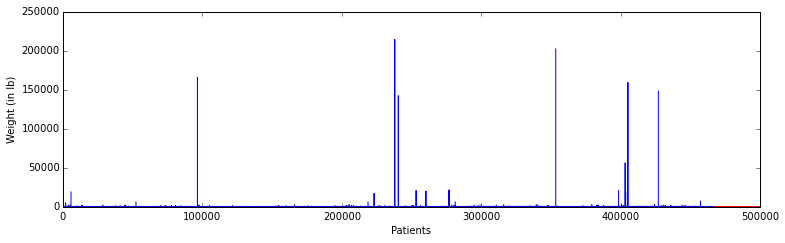

In [36]:
outliers = []
weight_threshold = 1000
weights = combined_df.FND_WTLB.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(weights)
plt.xlabel('Patients')
plt.ylabel('Weight (in lb)')
plt.axhline(y=weight_threshold, c="red",linewidth=1,zorder=0)

weight_outliers = [i for i,val in enumerate(weights) if val > weight_threshold]
outliers.extend(weight_outliers)
print '# of patients with weights beyond', weight_threshold, 'lb:', len(weight_outliers)

### Height outliers

# of patients with heights beyond 120 inches = 155


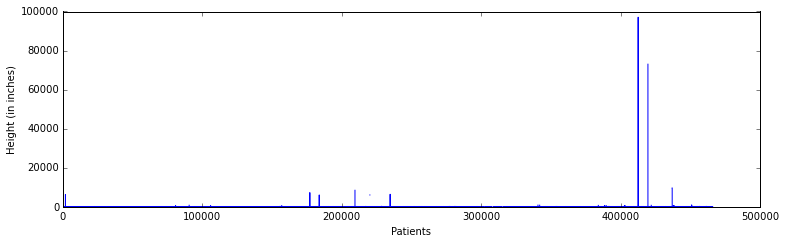

In [37]:
# Tallest man ever was 8 feet, so 10 feet is a safe threshold
height_threshold = 120
heights = combined_df.FND_HTIN.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(heights)
plt.xlabel('Patients')
plt.ylabel('Height (in inches)')
plt.axhline(y=height_threshold, c="red",linewidth=1,zorder=0)

height_outliers = [i for i,val in enumerate(heights) if val > height_threshold]
outliers.extend(height_outliers)
print '# of patients with heights beyond', height_threshold, 'inches =', len(height_outliers)

### Blood pressure outliers (systolic)

# of patients with systolic blood pressure beyond 200 is 456
# of patients with systolic blood pressure < 0 is 1


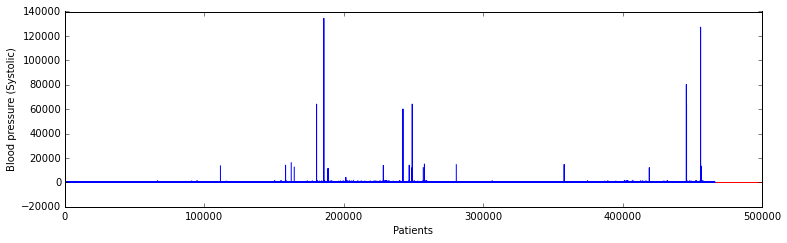

In [38]:
bp_threshold = 200
values = combined_df.FND_BPS.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(values)
plt.xlabel('Patients')
plt.ylabel('Blood pressure (Systolic)')
plt.axhline(y=bp_threshold, c="red",linewidth=1,zorder=0)

bp_outliers = [i for i,val in enumerate(values) if val > bp_threshold]
print '# of patients with systolic blood pressure beyond', bp_threshold, 'is', len(bp_outliers)
print '# of patients with systolic blood pressure < 0 is', len([i for i,val in enumerate(values) if val < 0])
outliers.extend(bp_outliers)
outliers.extend([i for i,val in enumerate(values) if val < 0])

### Blood pressure outliers (diastolic)

# of patients with diastolic blood pressure beyond 200 is 57


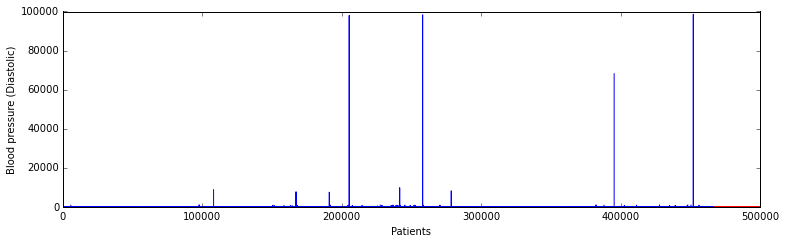

In [39]:
bp_threshold = 200
values = combined_df.FND_BPD.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(values)
plt.xlabel('Patients')
plt.ylabel('Blood pressure (Diastolic)')
plt.axhline(y=bp_threshold, c="red",linewidth=1,zorder=0)

bp_outliers = [i for i,val in enumerate(values) if val > bp_threshold]
outliers.extend(bp_outliers)
print '# of patients with diastolic blood pressure beyond', bp_threshold, 'is', len(bp_outliers)

### eGFR outliers

# of patients with eGFR values beyond 200 inches = 58


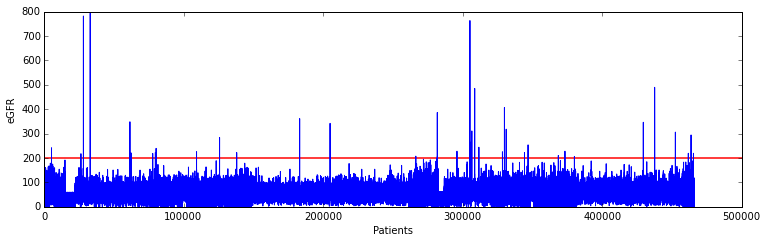

In [40]:
gfr_threshold = 200
values = combined_df.gfr.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(values)
plt.xlabel('Patients')
plt.ylabel('eGFR')
plt.axhline(y=gfr_threshold, c="red",linewidth=1.5,zorder=0)

gfr_outliers = [i for i,val in enumerate(values) if val > gfr_threshold]
outliers.extend(gfr_outliers)
print '# of patients with eGFR values beyond', gfr_threshold, 'inches =', len(gfr_outliers)

### AST (Aspartate Aminotransferase) outliers
#### Typically, the normal range for the AST test is 10 to 34 IU/L (international units per liter). Levels of AST greater than 10 times the normal limit usually indicate a viral hepatitis infection, that is over 340. So taking a threshold of 1000 should be safe since even in the most sever infection, AST test values should not cross that threshold

# of patients with AST values beyond 1000 IU/L = 13


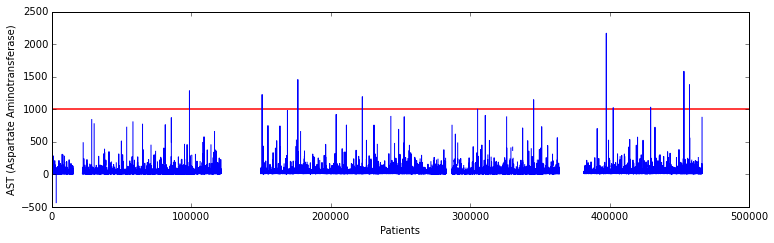

In [41]:
AST_threshold = 1000
values = combined_df.LR_AST.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(values)
plt.xlabel('Patients')
plt.ylabel('AST (Aspartate Aminotransferase)')
plt.axhline(y=AST_threshold, c="red",linewidth=1.5,zorder=0)

AST_outliers = [i for i,val in enumerate(values) if val > AST_threshold]
outliers.extend(AST_outliers)
print '# of patients with AST values beyond', AST_threshold, 'IU/L =', len(AST_outliers)

### Triglycerides outliers
#### Normal triglycerides means there are less than 150 milligrams per deciliter (mg/dL). Borderline high triglycerides = 150 to 199 mg/dL. Very high triglycerides = 500 mg/dL or higher. The highest world record (http://www.guinnessworldrecords.com/world-records/highest-triglyceride-level/) for triglyceride reading was 3165 mg/dl, 21 times the normal level of 150 mg/dl


# of patients with Triglycerides values beyond 3165 mg/dL = 44


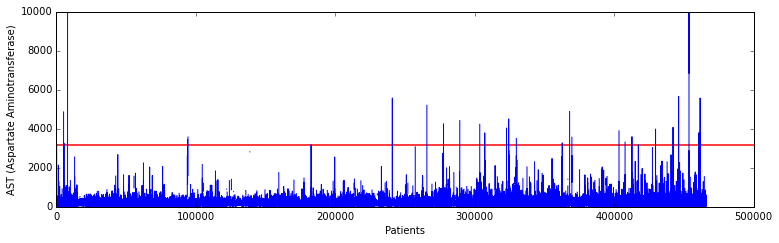

In [42]:
TRIG_threshold = 3165
values = combined_df.LR_TRIG.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(values)
plt.xlabel('Patients')
plt.ylabel('AST (Aspartate Aminotransferase)')
plt.axhline(y=TRIG_threshold, c="red",linewidth=1.5,zorder=0)

TRIG_outliers = [i for i,val in enumerate(values) if val > TRIG_threshold]
outliers.extend(TRIG_outliers)
print '\n# of patients with Triglycerides values beyond', TRIG_threshold, 'mg/dL =', len(TRIG_outliers)

### Creatinine level outliers
#### Normal creatinine levels range from 0.7 to 1.3 mg/dL in men and 0.6 to 1.1 mg/dL in women. Anything more then 2 is acute and 5 is chronic and needs urgent intervention. The highest ever recorded creatine level was 61.3 mg/dL, so taking 100 as a threshold is appropriate.

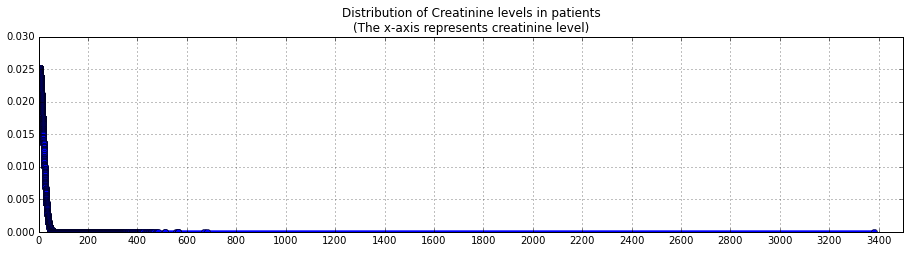

In [43]:
def plot_pdf(data, title):
    data.sort()
    
    figure = plt.figure()
    figure.set_size_inches(15.5, 3.5)
    pdf = stats.norm.pdf(data, np.mean(data), np.std(data))
    plt.plot(data, pdf, '-o', linewidth=3)
    plt.grid()
    plt.title(title)
    plt.xticks(range(0,3500,200))
    plt.show()
    
vals = [x for x in combined_df.LR_CR.values if not math.isnan(x)]
plot_pdf(vals, "Distribution of Creatinine levels in patients\n(The x-axis represents creatinine level)")


# of patients with Creatinine levels beyond 100 mg/dL = 2521


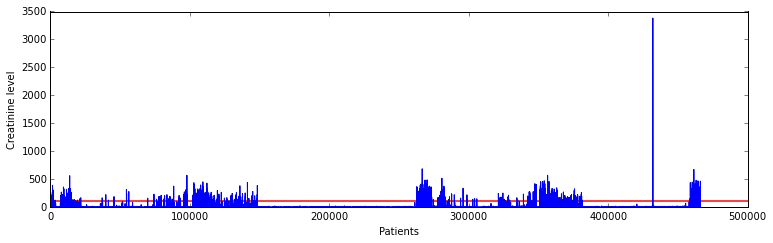

In [44]:
CR_threshold = 100
values = combined_df.LR_CR.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(values)
plt.xlabel('Patients')
plt.ylabel('Creatinine level')
plt.axhline(y=CR_threshold, c="red",linewidth=1.5,zorder=0)

CR_outliers = [i for i,val in enumerate(values) if val > CR_threshold]
outliers.extend(CR_outliers)
print '\n# of patients with Creatinine levels beyond', CR_threshold, 'mg/dL =', len(CR_outliers)

### Blood glucose level outliers
#### The normal blood sugar range is between 80-120 mg/dl, but the highest recorded glucose level was 2,656 mg/dl (http://www.guinnessworldrecords.com/world-records/highest-blood-sugar-level/)


# of patients with Glucose levels beyond 2656 mg/dL = 1


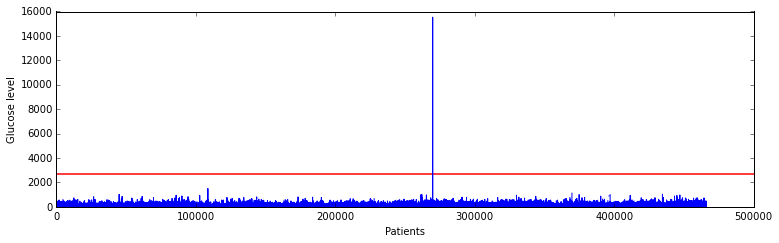

In [45]:
GLUCNONFAST_threshold = 2656
values = combined_df.LR_GLUCNONFAST.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(values)
plt.xlabel('Patients')
plt.ylabel('Glucose level')
plt.axhline(y=GLUCNONFAST_threshold, c="red",linewidth=1.5,zorder=0)

GLUCNONFAST_outliers = [i for i,val in enumerate(values) if val > GLUCNONFAST_threshold]
outliers.extend(GLUCNONFAST_outliers)
print '\n# of patients with Glucose levels beyond', GLUCNONFAST_threshold, 'mg/dL =', len(GLUCNONFAST_outliers)

### ALT (Alanine aminotransferase) outliers


# of patients with ALT levels beyond 1000 = 13


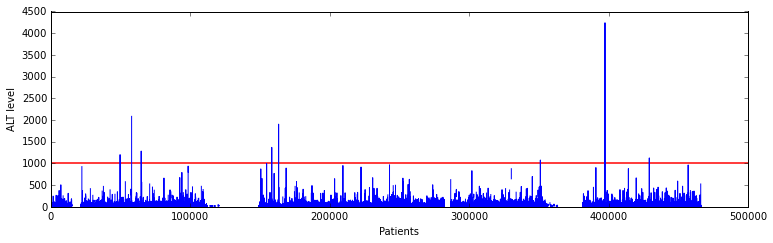

In [46]:
ALT_threshold = 1000
values = combined_df.LR_ALT.values

figure = plt.figure()
figure.set_size_inches(12.5, 3.5)
plt.plot(values)
plt.xlabel('Patients')
plt.ylabel('ALT level')
plt.axhline(y=ALT_threshold, c="red",linewidth=1.5,zorder=0)

ALT_outliers = [i for i,val in enumerate(values) if val > ALT_threshold]
outliers.extend(ALT_outliers)
print '\n# of patients with ALT levels beyond', ALT_threshold, '=', len(ALT_outliers)

## Remove the outliers

In [47]:
outliers = list(set(outliers))
combined_df.drop(combined_df.index[outliers], inplace=True)
print len(outliers), "outliers were removed."

3403 outliers were removed.


### Write the dataframe with removed outliers to CSV

In [49]:
output_file_path = 'combined_df_no_outliers.csv'
combined_df.to_csv(output_file_path, sep='\t')

In [12]:
# Read intermediate temporary file
combined_df = pd.read_csv('combined_df_no_outliers.csv', delimiter='\t', index_col=('pid','timestamp'))

## Convert categorical features to numerical ones

In [13]:
def categorical_to_numeric(col_name, df):
    column_values = df[col_name].values
    unique_values = np.unique(column_values)
    unique_values = [x for x in unique_values if type(x) is str]
        
    dicto = {value: index for (index, value) in enumerate(unique_values)}
    df.replace({col_name: dicto}, inplace=True)

categorical_to_numeric('smoker_status', combined_df)
categorical_to_numeric('gender', combined_df)

# Normalize the data

In [15]:
for col in combined_df.columns[3:-1]:
    colvalues = combined_df[col].values
    maxval = np.nanmax(colvalues)
    normalized_values = np.divide(colvalues, maxval)
    combined_df[col] = normalized_values
    print "The", col, "column has been normalized."

The smoker_status column has been normalized.
The FND_WTLB column has been normalized.
The FND_BPS column has been normalized.
The FND_BPD column has been normalized.
The FND_HTIN column has been normalized.
The LR_AST column has been normalized.
The LR_HDL column has been normalized.
The LR_TRIG column has been normalized.
The LR_A1C column has been normalized.
The LR_CR column has been normalized.
The LR_GLUCNONFAST column has been normalized.
The LR_LDL column has been normalized.
The LR_GFR column has been normalized.
The LR_ALT column has been normalized.
The LR_GFR_AFRAMER column has been normalized.


In [18]:
# Display the normalized dataframe
combined_df

gender  birthyear  age  smoker_status  FND_WTLB  FND_BPS  \
pid     timestamp                                                              
8545332 2006-08-11       0       1924   90            0.5  0.191439    0.600   
        2006-11-02       0       1924   90            0.5  0.195832    0.590   
        2007-06-05       0       1924   90            0.5  0.197088    0.750   
        2010-02-09       0       1924   90            0.5  0.204620    0.820   
        2010-08-17       0       1924   90            0.5  0.203364    0.675   
        2011-04-13       0       1924   90            0.5  0.204620    0.730   
8545333 2007-05-31       0       1941   73            0.0  0.184534    0.650   
        2010-06-10       0       1941   73            0.0       NaN      NaN   
        2010-06-10       0       1941   73            0.0       NaN      NaN   
8545336 2010-11-18       0       1928   86            0.0  0.151896    0.735   
        2011-09-01       0       1928   86            0.0  0.141853    0.575   
8545337 2010-10-29       0       1924   90            0.5       NaN    0.600   
8545338 2007-10-11       0       1948   66            0.0  0.177002    0.700   
8545339 2010-05-24       0       1946   68            0.0  0.338940    0.775   
        2010-05-24       0       1946   68            0.0  0.338940    0.775   
8545340 2007-04-19       0       1926   88            0.0  0.177002    0.700   
        2007-10-01       0       1926   88            0.0  0.311323    0.700   
        2007-10-09       0       1926   88            0.0       NaN      NaN   
        2008-12-18       0       1926   88            0.0  0.188300      NaN   
8545341 2006-12-06       0       1943   71            NaN  0.229726    0.660   
        2007-03-26       0       1943   71            NaN  0.237258    0.590   
8545342 2007-02-20       0       1931   83            0.5  0.160683    0.530   
        2007-07-19       0       1931   83            0.5  0.160683    0.560   
8545344 2007-11-26       0       1954   60            1.0  0.243535    0.640   
8545345 2009-06-25       0       1950   64            0.5  0.370324    0.530   
8545346 2009-01-15       0       1950   64            0.0  0.160683    0.695   
8545347 2010-10-29       0       1955   59            0.0  0.220939    0.615   
        2010-10-29       0       1955   59            0.0  0.220939    0.615   
8545348 2006-08-10       0       1941   73            0.0  0.247301    0.900   
        2009-05-04       0       1941   73            0.0  0.228471    0.685   
...                    ...        ...  ...            ...       ...      ...   
9581789 2011-09-13       1       1929   85            NaN       NaN      NaN   
9581790 2011-05-06       1       1925   89            NaN  0.134323    0.600   
9581791 2011-08-29       1       1928   86            NaN       NaN      NaN   
9581793 2011-09-02       1       1935   79            0.5       NaN      NaN   
        2011-09-02       1       1935   79            0.5       NaN      NaN   
        2011-11-08       1       1935   79            0.5       NaN      NaN   
        2012-02-15       1       1935   79            0.5       NaN      NaN   
        2012-03-01       1       1935   79            0.5       NaN      NaN   
9581799 2011-06-24       1       1926   88            NaN       NaN      NaN   
9581800 2011-01-06       1       1936   78            NaN       NaN      NaN   
        2011-03-08       1       1936   78            NaN       NaN      NaN   
        2011-08-08       1       1936   78            NaN       NaN      NaN   
        2011-10-18       1       1936   78            NaN       NaN      NaN   
        2012-01-24       1       1936   78            NaN       NaN      NaN   
9581801 2011-03-30       1       1942   72            NaN       NaN      NaN   
        2011-07-20       1       1942   72            NaN       NaN      NaN   
        2011-08-16       1       1942   72            NaN       NaN      NaN   
        2011-11-19  

### Write the normalized dataframe to CSV

In [17]:
output_file_path = 'combined_df_normalized.csv'
combined_df.to_csv(output_file_path, sep='\t')

In [3]:
# Read CSV with combined, filtered, and normalized data
combined_df = pd.read_csv('combined_df_normalized.csv', delimiter='\t')

## Fill in interpolated feature values

#### Spline interpolations with order=2

In [4]:
current_method = 'spline'
interpolated_spline2 = combined_df.interpolate(method=current_method, order=2, limit_direction='both', limit=100000)
interpolated_spline2

pid   timestamp  gender  birthyear  age  smoker_status  FND_WTLB  \
0       8545332  2006-08-11       0       1924   90       0.500000  0.191439   
1       8545332  2006-11-02       0       1924   90       0.500000  0.195832   
2       8545332  2007-06-05       0       1924   90       0.500000  0.197088   
3       8545332  2010-02-09       0       1924   90       0.500000  0.204620   
4       8545332  2010-08-17       0       1924   90       0.500000  0.203364   
5       8545332  2011-04-13       0       1924   90       0.500000  0.204620   
6       8545333  2007-05-31       0       1941   73       0.000000  0.184534   
7       8545333  2010-06-10       0       1941   73       0.000000  0.221741   
8       8545333  2010-06-10       0       1941   73       0.000000  0.221741   
9       8545336  2010-11-18       0       1928   86       0.000000  0.151896   
10      8545336  2011-09-01       0       1928   86       0.000000  0.141853   
11      8545337  2010-10-29       0       1924   90       0.500000  0.221741   
12      8545338  2007-10-11       0       1948   66       0.000000  0.177002   
13      8545339  2010-05-24       0       1946   68       0.000000  0.338940   
14      8545339  2010-05-24       0       1946   68       0.000000  0.338940   
15      8545340  2007-04-19       0       1926   88       0.000000  0.177002   
16      8545340  2007-10-01       0       1926   88       0.000000  0.311323   
17      8545340  2007-10-09       0       1926   88       0.000000  0.221740   
18      8545340  2008-12-18       0       1926   88       0.000000  0.188300   
19      8545341  2006-12-06       0       1943   71       0.212857  0.229726   
20      8545341  2007-03-26       0       1943   71       0.212857  0.237258   
21      8545342  2007-02-20       0       1931   83       0.500000  0.160683   
22      8545342  2007-07-19       0       1931   83       0.500000  0.160683   
23      8545344  2007-11-26       0       1954   60       1.000000  0.243535   
24      8545345  2009-06-25       0       1950   64       0.500000  0.370324   
25      8545346  2009-01-15       0       1950   64       0.000000  0.160683   
26      8545347  2010-10-29       0       1955   59       0.000000  0.220939   
27      8545347  2010-10-29       0       1955   59       0.000000  0.220939   
28      8545348  2006-08-10       0       1941   73       0.000000  0.247301   
29      8545348  2009-05-04       0       1941   73       0.000000  0.228471   
...         ...         ...     ...        ...  ...            ...       ...   
462668  9581789  2011-09-13       1       1929   85       0.191974  0.283098   
462669  9581790  2011-05-06       1       1925   89       0.191974  0.134323   
462670  9581791  2011-08-29       1       1928   86       0.191974  0.283099   
462671  9581793  2011-09-02       1       1935   79       0.500000  0.283099   
462672  9581793  2011-09-02       1       1935   79       0.500000  0.283099   
462673  9581793  2011-11-08       1       1935   79       0.500000  0.283100   
462674  9581793  2012-02-15       1       1935   79       0.500000  0.283100   
462675  9581793  2012-03-01       1       1935   79       0.500000  0.283100   
462676  9581799  2011-06-24       1       1926   88       0.191974  0.283101   
462677  9581800  2011-01-06       1       1936   78       0.191974  0.283101   
462678  9581800  2011-03-08       1       1936   78       0.191974  0.283101   
462679  9581800  2011-08-08       1       1936   78       0.191974  0.283102   
462680  9581800  2011-10-18       1       1936   78       0.191974  0.283102   
462681  9581800  2012-01-24       1       1936   78       0.191974  0.283102   
462682  9581801  2011-03-30       1       1942   72       0.191974  0.283103   
462683  9581801  2011-07-20       1       1942   72       0.191974  0.283103   
462684  9581801  2011-08-16       1       1942   72       0.191974  0.283103   
462685  9581801  2011-11-19       1       1942   72       0.191974  0.283104   
462686  9581

Creatinine levels after spline interpolation


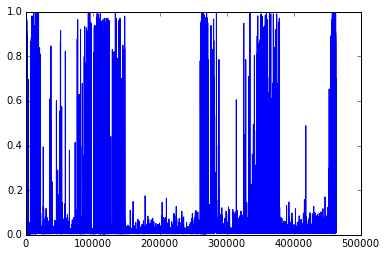

In [5]:
plt.plot(interpolated_spline2['LR_CR'])
print "Creatinine levels after spline interpolation"

#### Spline interpolations with order=3

In [6]:
current_method = 'spline'
interpolated_spline3 = combined_df.interpolate(method=current_method, order=3, limit_direction='both', limit=100000)

### Check if there's any NaN values still remaining in any feature column

In [15]:
interpolated_spline3.isnull().sum()

pid               0
timestamp         0
gender            0
birthyear         0
age               0
smoker_status     0
FND_WTLB          0
FND_BPS           0
FND_BPD           0
FND_HTIN          0
LR_AST            0
LR_HDL            0
LR_TRIG           0
LR_A1C            0
LR_CR             0
LR_GLUCNONFAST    0
LR_LDL            0
LR_GFR            0
LR_ALT            0
LR_GFR_AFRAMER    0
gfr               0
dtype: int64

In [10]:
combined_df

pid   timestamp  gender  birthyear  age  smoker_status  FND_WTLB  \
0       8545332  2006-08-11       0       1924   90            0.5  0.191439   
1       8545332  2006-11-02       0       1924   90            0.5  0.195832   
2       8545332  2007-06-05       0       1924   90            0.5  0.197088   
3       8545332  2010-02-09       0       1924   90            0.5  0.204620   
4       8545332  2010-08-17       0       1924   90            0.5  0.203364   
5       8545332  2011-04-13       0       1924   90            0.5  0.204620   
6       8545333  2007-05-31       0       1941   73            0.0  0.184534   
7       8545333  2010-06-10       0       1941   73            0.0       NaN   
8       8545333  2010-06-10       0       1941   73            0.0       NaN   
9       8545336  2010-11-18       0       1928   86            0.0  0.151896   
10      8545336  2011-09-01       0       1928   86            0.0  0.141853   
11      8545337  2010-10-29       0       1924   90            0.5       NaN   
12      8545338  2007-10-11       0       1948   66            0.0  0.177002   
13      8545339  2010-05-24       0       1946   68            0.0  0.338940   
14      8545339  2010-05-24       0       1946   68            0.0  0.338940   
15      8545340  2007-04-19       0       1926   88            0.0  0.177002   
16      8545340  2007-10-01       0       1926   88            0.0  0.311323   
17      8545340  2007-10-09       0       1926   88            0.0       NaN   
18      8545340  2008-12-18       0       1926   88            0.0  0.188300   
19      8545341  2006-12-06       0       1943   71            NaN  0.229726   
20      8545341  2007-03-26       0       1943   71            NaN  0.237258   
21      8545342  2007-02-20       0       1931   83            0.5  0.160683   
22      8545342  2007-07-19       0       1931   83            0.5  0.160683   
23      8545344  2007-11-26       0       1954   60            1.0  0.243535   
24      8545345  2009-06-25       0       1950   64            0.5  0.370324   
25      8545346  2009-01-15       0       1950   64            0.0  0.160683   
26      8545347  2010-10-29       0       1955   59            0.0  0.220939   
27      8545347  2010-10-29       0       1955   59            0.0  0.220939   
28      8545348  2006-08-10       0       1941   73            0.0  0.247301   
29      8545348  2009-05-04       0       1941   73            0.0  0.228471   
...         ...         ...     ...        ...  ...            ...       ...   
462668  9581789  2011-09-13       1       1929   85            NaN       NaN   
462669  9581790  2011-05-06       1       1925   89            NaN  0.134323   
462670  9581791  2011-08-29       1       1928   86            NaN       NaN   
462671  9581793  2011-09-02       1       1935   79            0.5       NaN   
462672  9581793  2011-09-02       1       1935   79            0.5       NaN   
462673  9581793  2011-11-08       1       1935   79            0.5       NaN   
462674  9581793  2012-02-15       1       1935   79            0.5       NaN   
462675  9581793  2012-03-01       1       1935   79            0.5       NaN   
462676  9581799  2011-06-24       1       1926   88            NaN       NaN   
462677  9581800  2011-01-06       1       1936   78            NaN       NaN   
462678  9581800  2011-03-08       1       1936   78            NaN       NaN   
462679  9581800  2011-08-08       1       1936   78            NaN       NaN   
462680  9581800  2011-10-18       1       1936   78            NaN       NaN   
462681  9581800  2012-01-24       1       1936   78            NaN       NaN   
462682  9581801  2011-03-30       1       1942   72            NaN       NaN   
462683  9581801  2011-07-20       1       1942   72            NaN       NaN   
462684  9581801  2011-08-16       1       1942   72            NaN       NaN   
462685  9581801  2011-11-19       1       1942   72            NaN       NaN   
462686  9581

### Write the interpolated values to a csv

In [7]:
# Spline interpolation with order=2
output_file_path = 'combined_df_spline2.csv'
interpolated_spline2.to_csv(output_file_path, sep='\t')

# Spline interpolation with order=3
output_file_path = 'combined_df_spline3.csv'
interpolated_spline3.to_csv(output_file_path, sep='\t')